# HAMS data challenge
By Ryan Henderson

## Setup

In [1]:
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import numpy as np

import seaborn as sns

import pandas as pd

In [2]:
df = pd.read_csv('sample.csv')

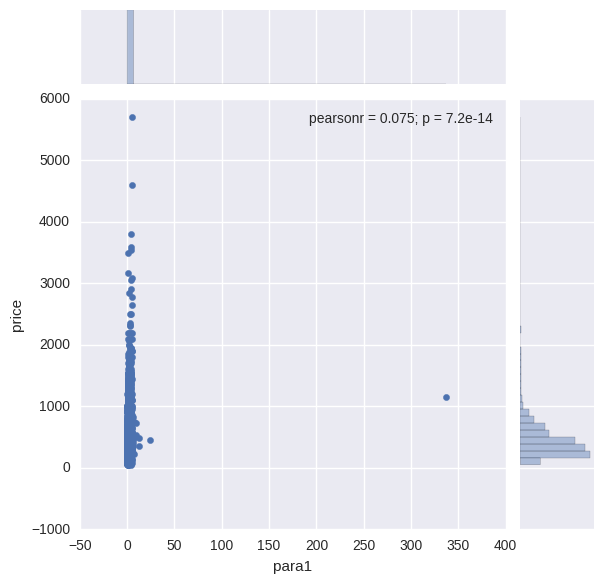

In [3]:
sns.jointplot(x='para1', y='price', data=df)

In [4]:
df = df[(df.para1 < 300)]

In [5]:
# set up fit/transform methods
scaler = StandardScaler()
linear_regerssor = LinearRegression()
sgd_regressor = SGDRegressor()
ada_regressor = AdaBoostRegressor()
forest_regressor = RandomForestRegressor()

# set up pipelines
pipelines = {}
pipelines['linear'] = Pipeline([('scale', scaler), ('linear_regression', linear_regerssor)])
pipelines['sgd'] = Pipeline([('scale', scaler), ('sgd_regression', sgd_regressor)])
# forest/tree algorithms don't need scaling
pipelines['ada'] = Pipeline([('ada_regression', ada_regressor)])
pipelines['forest'] = Pipeline([('forest_regression', forest_regressor)])

## Parameter Features

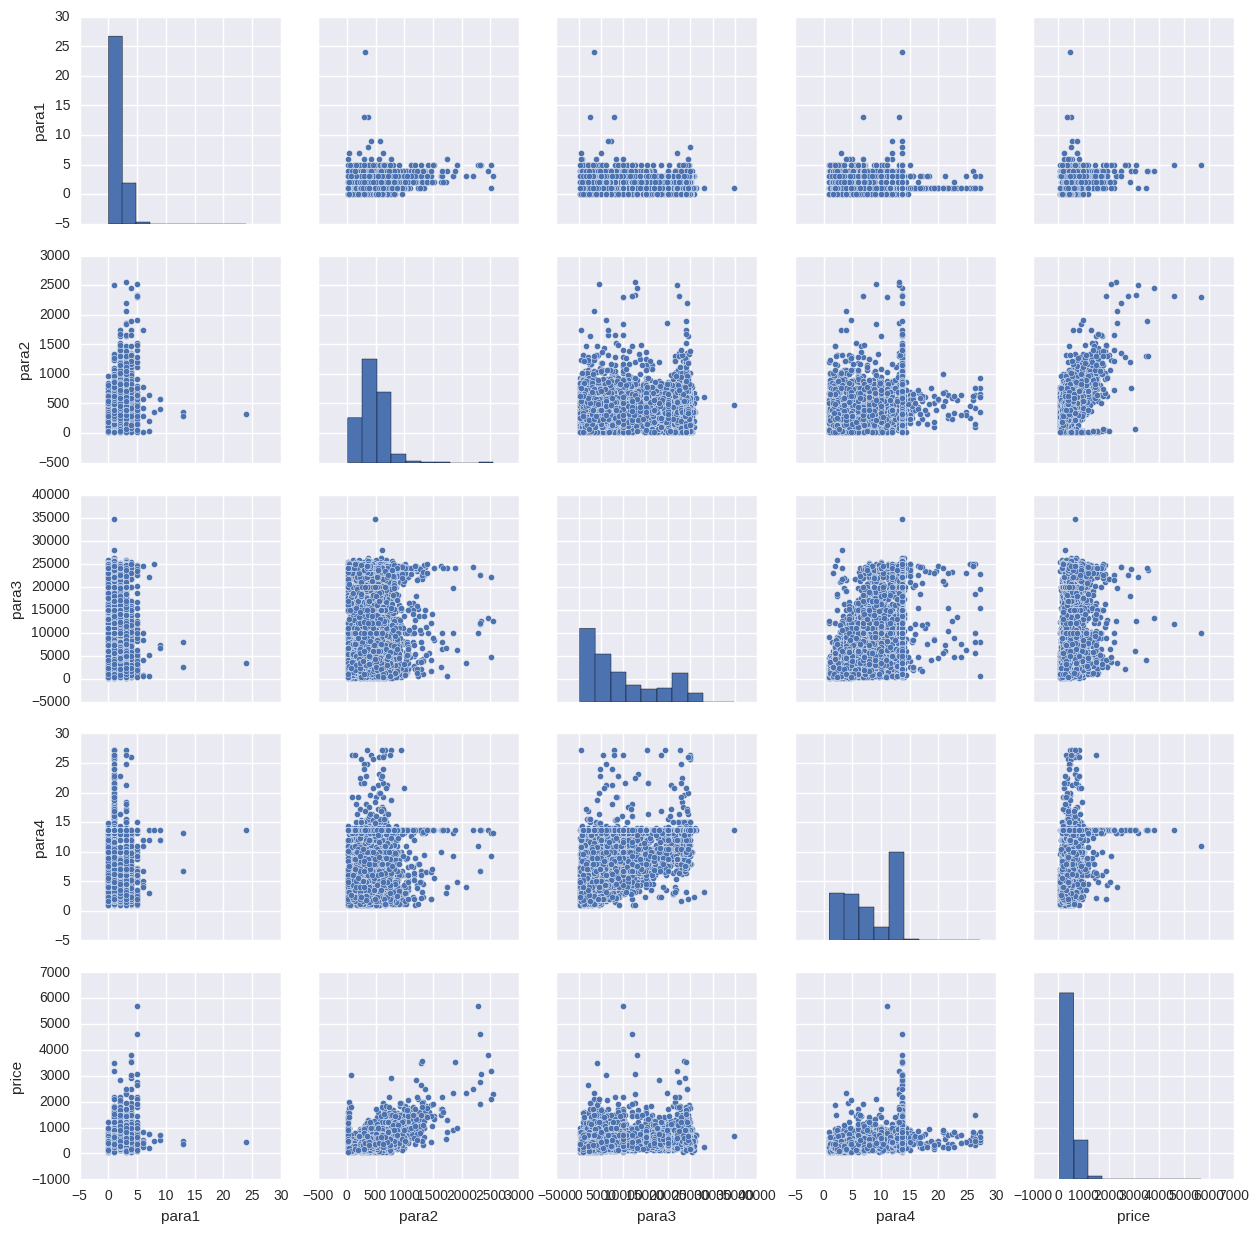

In [6]:
sns.pairplot(df[['para1', 'para2', 'para3', 'para4', 'price']])

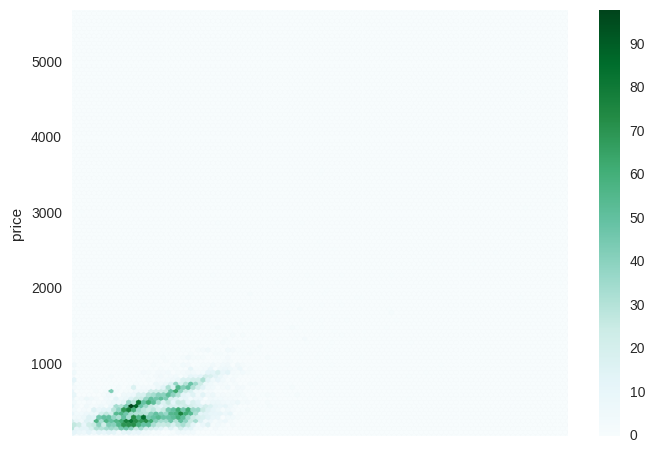

In [7]:
df.plot(kind='hexbin', x='para2', y='price')

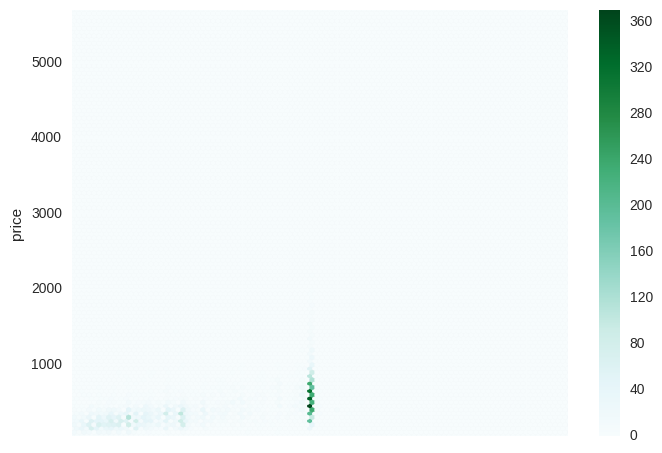

In [8]:
df.plot(kind='hexbin', x='para4', y='price')

In [9]:
# extract features and target
X_df = df[['para1', 'para2', 'para3', 'para4']]
y_df = df['price']
# split into test and train
X, X_test, y, y_test = train_test_split(X_df.values, y_df.values)

In [10]:
def compare_models(X, X_test, y, y_test):
    for model in pipelines:
        pipelines[model].fit(X, y)
        y_pred = pipelines[model].predict(X)
        y_pred_test = pipelines[model].predict(X_test)
        
        print '\n\n' + model
        print 'MAE train: ' + str(mean_absolute_error(y, y_pred))
        print 'R2 train: ' + str(r2_score(y, y_pred)) + '\n'
        print 'MAE test: ' + str(mean_absolute_error(y_test, y_pred_test))
        print 'R2 test: ' + str(r2_score(y_test, y_pred_test))

In [11]:
compare_models(X, X_test, y, y_test)



forest
MAE train: 40.4561494574
R2 train: 0.927592168954

MAE test: 104.100335148
R2 test: 0.65107877125


ada
MAE train: 156.656664398
R2 train: 0.426512051351

MAE test: 160.346312976
R2 test: 0.413811767644


linear
MAE train: 113.875865955
R2 train: 0.563507627749

MAE test: 116.849782366
R2 test: 0.557368273287


sgd
MAE train: 113.537855186
R2 train: 0.563161996381

MAE test: 116.46000317
R2 test: 0.555835351646


## Day-of-week features

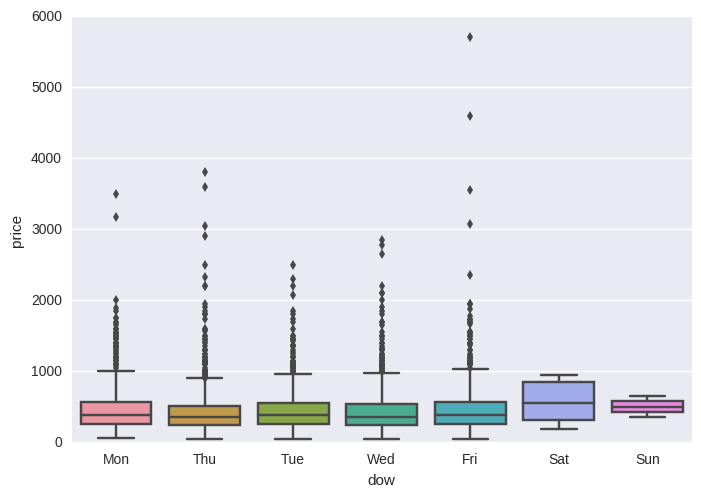

In [12]:
sns.boxplot(x='dow', y='price', data=df)

In [13]:
df.dow.value_counts()

Wed    2233
Tue    1997
Fri    1931
Mon    1917
Thu    1908
Sat      10
Sun       3
Name: dow, dtype: int64

In [14]:
X_df = df[['dow', 'para1', 'para2', 'para3', 'para4']]
X_df = pd.concat([pd.get_dummies(X_df.dow), X_df], axis=1).drop('dow', axis=1)
X, X_test, y, y_test = train_test_split(X_df.values, y_df.values)

In [15]:
X_df.head()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,para1,para2,para3,para4
0,0,1,0,0,0,0,0,1,662,3000.0,3.8
1,0,0,0,0,1,0,0,1,340,2760.0,9.2
2,0,1,0,0,0,0,0,0,16,2700.0,3.0
3,0,1,0,0,0,0,0,1,17,12320.0,6.4
4,0,0,0,0,1,0,0,1,610,2117.0,10.8


In [16]:
compare_models(X, X_test, y, y_test)



forest
MAE train: 40.3057844602
R2 train: 0.940667531032

MAE test: 102.042205333
R2 test: 0.605214343056


ada
MAE train: 217.329567463
R2 train: 0.168179808928

MAE test: 219.592241097
R2 test: 0.0224214118687


linear
MAE train: 115.69451857
R2 train: 0.567918487111

MAE test: 114.011564743
R2 test: 0.548145783102


sgd
MAE train: 1902.78748679
R2 train: -133205.869117

MAE test: 2741.65908341
R2 test: -217351.767938


## Location features

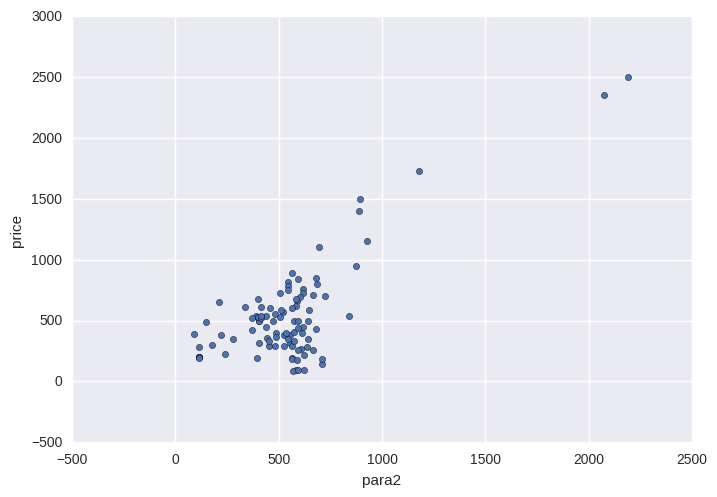

In [17]:
df[df.loc2 == '03'].plot(kind='scatter', x='para2', y='price')

In [18]:
df.loc2.str[0].value_counts()

2    1607
0    1486
1    1223
7    1081
3     945
5     846
4     773
8     727
9     690
6     619
T       1
S       1
Name: loc2, dtype: int64

In [19]:
df.loc2.str[1].value_counts()

1    1317
9    1258
6    1123
4    1098
7     902
3     895
2     886
0     858
8     832
5     824
B       1
T       1
L       1
N       1
S       1
C       1
Name: loc2, dtype: int64

In [20]:
df.loc2 = df.loc2.str[1]
df_dropped_codes = df[df.loc1.isin(map(str, range(10))) & df.loc2.isin(map(str, range(10)))]

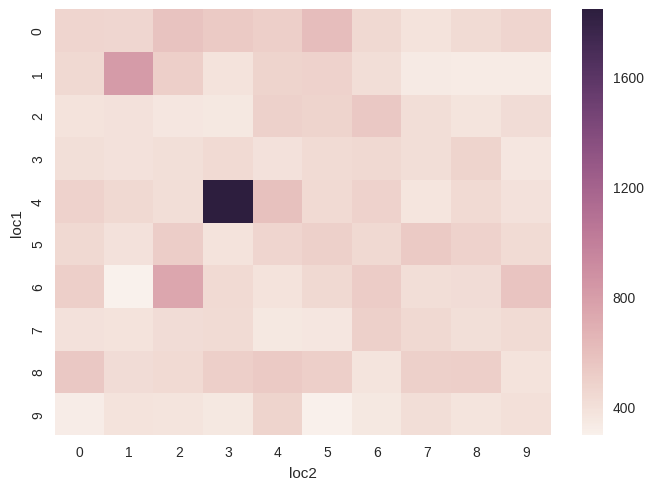

In [21]:
sns.heatmap(df_dropped_codes.groupby(['loc1', 'loc2']).price.mean().unstack())

In [22]:
def bin_locs(df, bins=5):
    _df = df.copy()
    loc_codes = df_dropped_codes.groupby(['loc1', 'loc2']).price.mean().unstack()
    bin_thresholds = np.percentile(loc_codes, np.linspace(0, 100, bins))

    bin_thresholds = bin_thresholds.tolist()
    
    bin_thresholds.reverse()
    
    _df['loc_val'] = np.nan
    for upper_threshold in bin_thresholds:
        for i in range(10):
            for j in range(10):
                i = str(i)
                j = str(j)
                if loc_codes.loc[i][j] <= upper_threshold:
                    _df['loc_val'][(_df.loc1 == i) & (_df.loc2 == j)] = upper_threshold
    return _df

In [23]:
df_loc_val = bin_locs(df_dropped_codes)

/home/ryan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
X_df = df_loc_val[['loc_val', 'para1', 'para2', 'para3', 'para4']]
y_df = df_loc_val['price']
X, X_test, y, y_test = train_test_split(X_df.values, y_df.values)

In [25]:
compare_models(X, X_test, y, y_test)



forest
MAE train: 39.4464371667
R2 train: 0.93841252341

MAE test: 99.3850936574
R2 test: 0.650809611301


ada
MAE train: 199.940936239
R2 train: 0.246144349421

MAE test: 207.356126825
R2 test: 0.175837003136


linear
MAE train: 113.773562197
R2 train: 0.572583863702

MAE test: 116.08912706
R2 test: 0.539596607469


sgd
MAE train: 112.976913114
R2 train: 0.571770210956

MAE test: 115.450614361
R2 test: 0.538328265904


In [ ]:
df_loc_val = bin_locs(df_dropped_codes, bins=10)
X_df = df_loc_val[['loc_val', 'para1', 'para2', 'para3', 'para4']]
y_df = df_loc_val['price']
X, X_test, y, y_test = train_test_split(X_df.values, y_df.values)
compare_models(X, X_test, y, y_test)

/home/ryan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Summary, suggested Improvements